In [ ]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:

import numpy as np
import pyomo
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *
import time

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import os
pwd = '/content/drive/MyDrive/Colab Notebooks/Fair Fares/INFORMS/Official_Upload/Case_Study'
with open(os.path.join(pwd, 'data_dictionary_logistic.pkl'), 'rb') as f:
    data = pickle.load(f)

### Import Data

In [ ]:
print(data.keys())
L = data['market_size'].keys()
n = len(L)

dict_keys(['market_size', 'beta', 'k', 'avg_dist', 'avg_time', 'uber'])


In [ ]:
print(data['k'])

                1            2            3           4            5   \
1              NaN    63.925892    42.531637   362.75614   114.565358   
2        57.122403          NaN     78.16046  106.767974  1388.198532   
3        50.530308   121.687836          NaN   61.486235    77.812479   
4       637.492549   148.070395   135.122076         NaN   103.441486   
5       138.596684   720.286574   165.899929  105.143144          NaN   
6       271.179647   252.932521    78.709917  114.258923   101.782763   
7     11679.732453  1150.224442  1101.824296  110.894941     315.9395   
8      9263.031358   480.683714   494.485558  243.532424   108.162575   
9    386003.950418  1465.653078   518.457583  237.571853    207.26584   
10  3130266.361763  2308.133989   954.424592  219.289979    54.526467   

            6            7           8             9             10  
1   372.467002  1442.570979   57.542293  25210.945521    370.032921  
2     57.93252   148.724248  170.500031    354.941707  1

In [ ]:
market, b, k, d, t = {}, {}, {}, {}, {}
m = 0
for i in L:
  for j in L:
    market[i,j] = data['market_size'].loc[i,j]
    b[i,j] = data['beta'].loc[i,j]
    k[i,j] = data['k'].loc[i,j]
    d[i,j] = data['avg_dist'].loc[i,j]
    t[i,j] = data['avg_time'].loc[i,j]
    m += data['uber']['num'].loc[i,j] if i != j else 0

In [ ]:
print('number of cars', m)
print('total market size', sum(market.values()))

number of cars 20165
total market size 36409


In [ ]:
param = {'market': market, 'b': b, 'k': k, 'd': d, 'n': n, 'm': m, 't': t}

### Buzen's Algorithm

In [ ]:
def buzens_algorithm(N, M, r):
    max_r = max(r)
    r = [ri/max_r for ri in r]
    C = [1] + [0 for _ in range(M)]
    r = [None] + r
    C_num = 0
    for n in range(1, N+1):
      for m in range(1, M+1):
        C[m] = C[m] + r[n] * C[m-1]
    return r[N] * C[M-1]/C[M]

def get_pi(N, M, r):
  pi = {}
  for loc in range(len(r)):
    r_i = r[0:loc] + r[loc+1:] + [r[loc]]
    pi[loc+1] = buzens_algorithm(N, M, r_i)
  return pi

In [ ]:
import numpy as np
def get_r(Lambda, n):
  # convert dictionary to numpy array
  # inflow == outflow
  lambda_i_ = np.sum(Lambda, axis = 1) # sum_{j} lambda_ij
  A = Lambda.T - np.diag(lambda_i_)

  # Perform SVD on A
  U, s, Vt = np.linalg.svd(A)

  # Find the null space of A
  null_space = Vt.T[:, np.isclose(s, 0)]

  # Print a non-zero solution
  if null_space.size == 0:
      print("No non-zero solutions.")
  else:
      solution = null_space[:, 0]
      solution = np.abs(solution).tolist()
  pos = [element for element in solution if element > 0]
  return pos

## Example
Lambda = np.asarray([[0, 1/2,],[1/2, 0]])
r = get_r(Lambda, 2)
print(type(r))
print(r[0], r[1])

<class 'list'>
0.7071067811865475 0.7071067811865476


In [ ]:
def true_value(param, q):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  Lambda = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      Lambda[i,j] = market[i+1,j+1] * q[i+1, j+1]
  r = get_r(Lambda, n)
  #z_n, z_d = buzens_algorithm(n, m, r)
  #print(f"buzens_algorithm z_n/z_d: {z_n} and {z_d}")


  # if np.isinf(z_n):
  #   print(r)
  #   raise ValueError('Value error: z_n is infinity')
  # if np.isinf(z_d):
  #   print(r)
  #   raise ValueError('Value error: z_d is infinity')

  # A = 1 if np.isnan(z_n) or np.isnan(z_d) or np.isinf(z_n) or np.isinf(z_d) else z_n/z_d
  # L = [i for i in range(1,n+1)]
  # pi = {l:r[l-1]*A for l in L}
  pi = get_pi(n, m, r)
  #print('true_value')
  #print(f"r is {r}")
  #print(f"pi is {pi}")
  revenue = sum([market[i,j]*np.log(k[i,j] * (1-q[i,j])/q[i,j])/b[i,j]*q[i,j]*pi[i] if i != j else 0 for i in L for j in L])

  sur, access, price, total_surplus = {}, {}, {}, 0
  for i in L:
    for j in range(1, n+1):
      if i != j:
        price[i,j] = np.log(k[i,j] * (1-q[i,j])/q[i,j])/b[i,j]
        sur[i,j] = np.log(1+k[i,j]*np.exp(-b[i,j]*price[i,j])) * pi[i] / b[i,j]
        access[i,j] = q[i,j] * pi[i]
        total_surplus += market[i,j] * sur[i,j]

  return revenue, {'s': sur, 'ts': total_surplus, 'r': pi}, price, access

### Approximation Model

In [ ]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def approx_model(param, solver = 'ipopt', traveling_time = False, fairness='Price'):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  L = [i for i in range(1,n+1)]
  model = ConcreteModel()

  ### Step 2: Define the decision
  model.q = Var(L, L, domain = NonNegativeReals)
  # model.t = Var(L, L, domain = NonNegativeReals)

  ### Step 3: Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*(1-model.q[i,j])/model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j] if i != j else 0 for i in L for j in L]), sense=maximize)

  ### constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i] if k!= i else 0 for k in L]))
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      # model.c.add(model.t[i,j] == (1-model.q[i,j])/model.q[i,j])
      if i != j:
        m_list.append(model.q[i,j])

  if traveling_time:
    duration = param['t']
    model.c.add(sum([market[i,j]*model.q[i,j]*duration[i,j]/120 if i != j else 0 for i in L for j in L]) <= m)

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, price, access = true_value(param, org_q)

  if fairness == 'Price':
    p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  elif fairness == 'Access':
    weighted_p = []
    weighted_a = []
    for i in L:
      weighted_p.append(sum([market[i,j] * price[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]))
      weighted_a.append(sum([market[i,j] * access[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]))
    p_star = max(weighted_p) - min(weighted_p)
    a_star = max(weighted_a) - min(weighted_a)
  star = {'p': p_star, 'a': a_star}

  return {'ub': model.revenue(), 'lb': rev}, price, access, org_q, star, sur

### Run the model w/o fairness

In [ ]:
rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt')

In [ ]:
lhs = 0
for i in L:
  for j in L:
    if i != j:
      lhs += market[i,j] * org_q[i,j] * t[i,j]/120
print(lhs)
print(rev['ub'])
print(rev['lb'])

3448.351477759716
539500.1129295927
539259.4318045622


In [ ]:
p_max = max(p_ij, key=p_ij.get)
p_min = min(p_ij, key=p_ij.get)
print('maximum price: %.3f from %s' %(max(p_ij.values()), str(p_max)))
print('minimum price: %.3f from %s' %(min(p_ij.values()), str(p_min)))
print('price gap', max(p_ij.values()) - min(p_ij.values()))

maximum price: 70.571 from (1, 8)
minimum price: 12.068 from (9, 7)
price gap 58.5035158545376


In [ ]:
import pandas as pd
uber = data['uber']
p_avg = pd.DataFrame([[uber['sum_p'].loc[i,j]/uber['num'].loc[i,j] if i != j else 0 for j in range(1, n+1)] for i in range(1, n+1)])
p_avg.index = range(1, len(p_avg.index) + 1)
p_avg.columns = range(1, len(p_avg.columns) + 1)

print(p_avg.applymap(lambda x: round(x,1)))
print("="*20)
print('max:', p_avg.max().max())
min_value = p_avg[p_avg != 0].min().min()
print('min:', min_value)

      1     2     3     4     5     6     7     8     9     10
1    0.0  16.1  24.3  31.8  31.9  37.8  42.2  45.0  46.9  53.4
2   17.6   0.0  20.8  21.0  34.2  36.4  34.9  44.7  37.5  41.0
3   21.7  19.8   0.0  21.3  21.8  25.5  29.6  38.8  41.2  42.9
4   30.9  19.8  22.7   0.0  30.9  27.9  22.0  40.5  32.2  43.7
5   35.6  34.2  22.7  32.4   0.0  20.1  24.1  23.8  31.2  31.3
6   39.3  32.5  26.4  25.2  21.4   0.0  19.5  24.4  26.8  36.0
7   38.8  30.1  29.8  22.4  24.8  20.1   0.0  24.4  21.3  31.4
8   40.1  40.8  37.6  40.5  24.3  25.1  23.8   0.0  18.6  19.5
9   46.6  35.9  39.2  32.7  30.8  27.8  18.4  17.6   0.0  20.4
10  46.4  41.4  40.2  47.0  29.7  34.5  30.7  19.9  21.4   0.0
max: 53.449999999999996
min: 16.11853448275862


In [ ]:
# Convert the dictionary to a pandas DataFrame with values for diagonal elements
p_bar = pd.DataFrame([[p_ij[(i, j)] if i != j else 0 for j in range(1, n+1)] for i in range(1, n+1)])
p_bar.index = range(1, len(p_bar.index) + 1)
p_bar.columns = range(1, len(p_bar.columns) + 1)

# Display the resulting pandas DataFrame
print(p_bar.applymap(lambda x: round(x,2)))

print("="*20)
print('max:', p_bar.max().max())
min_value = p_bar[p_bar != 0].min().min()
print('min:', min_value)

       1      2      3      4      5      6      7      8      9      10
1    0.00  15.13  22.25  25.88  28.97  34.28  35.60  70.57  41.55  53.52
2   16.34   0.00  16.37  15.20  28.29  36.43  28.51  53.59  36.70  35.32
3   15.78  15.77   0.00  15.44  16.70  19.88  21.55  36.60  36.89  35.84
4   25.93  15.37  17.68   0.00  25.50  22.09  15.55  40.39  30.77  44.54
5   31.81  27.52  17.55  24.49   0.00  16.34  19.51  25.66  31.01  30.98
6   33.66  25.62  21.07  18.26  18.38   0.00  14.67  26.85  28.59  31.04
7   31.80  24.99  24.43  17.20  21.42  17.38   0.00  28.88  25.29  27.32
8   31.04  33.42  28.52  30.61  17.95  19.53  16.94   0.00  18.41  17.52
9   38.23  27.78  30.68  23.36  24.36  21.41  12.07  16.90   0.00  15.36
10  38.20  36.50  34.51  36.41  28.04  32.73  27.95  24.87  24.11   0.00
max: 70.57118917721776
min: 12.067673322680156


In [ ]:
p_unit = pd.DataFrame([[p_ij[(i, j)]/d[i,j] if i != j else 0 for j in range(1, n+1)] for i in range(1, n+1)])
p_unit.index = range(1, len(p_unit.index) + 1)
p_unit.columns = range(1, len(p_unit.columns) + 1)

# Display the resulting pandas DataFrame
print(p_unit.applymap(lambda x: round(x,2)))

      1     2     3     4      5      6      7      8      9      10
1   0.00  6.27  6.61  5.78   4.56   5.02   4.43   7.90   4.13   5.11
2   6.70  0.00  6.78  7.08   4.85   6.82   5.54   6.73   4.64   3.79
3   4.61  6.25  0.00  7.91   7.55   8.60   6.75   7.77   6.26   5.56
4   5.15  6.92  9.13  0.00   7.47   9.41   6.96   7.94   6.35   6.05
5   4.61  4.48  7.71  6.90   0.00  11.14   9.79  11.60   9.52   8.69
6   4.62  5.29  8.94  8.36  11.82   0.00  10.67  13.22  11.25   7.31
7   4.25  5.21  7.43  8.23  10.42  12.29   0.00  12.99  12.33   6.00
8   3.20  4.48  6.10  6.45   7.60   9.30   7.95   0.00  13.50  10.72
9   3.86  3.49  5.39  5.22   7.04   8.33   6.46  12.26   0.00   6.61
10  3.68  4.07  5.70  5.23   7.85   7.94   5.96  14.35   9.84   0.00


In [ ]:
error = p_bar - p_avg
print(error.applymap(lambda x: round(x,1)))
print("="*20)
print(error.abs().sum().sum())
print("="*20)
print(error.sum().sum())

     1    2    3     4    5    6    7     8    9    10
1   0.0 -1.0 -2.1  -5.9 -3.0 -3.5 -6.6  25.5 -5.4  0.1
2  -1.2  0.0 -4.4  -5.8 -5.9  0.0 -6.4   8.9 -0.8 -5.7
3  -5.9 -4.0  0.0  -5.9 -5.1 -5.6 -8.0  -2.2 -4.3 -7.0
4  -5.0 -4.4 -5.0   0.0 -5.4 -5.8 -6.4  -0.1 -1.4  0.8
5  -3.8 -6.7 -5.1  -7.9  0.0 -3.7 -4.6   1.9 -0.2 -0.3
6  -5.6 -6.9 -5.4  -6.9 -3.1  0.0 -4.8   2.4  1.8 -4.9
7  -7.0 -5.1 -5.4  -5.2 -3.4 -2.8  0.0   4.5  4.0 -4.1
8  -9.0 -7.3 -9.1  -9.9 -6.3 -5.6 -6.9   0.0 -0.1 -2.0
9  -8.4 -8.1 -8.5  -9.3 -6.4 -6.3 -6.3  -0.7  0.0 -5.1
10 -8.2 -4.9 -5.7 -10.5 -1.7 -1.7 -2.7   5.0  2.7  0.0
450.9716000677614
-335.6308255339082


In [ ]:
450.97/10/9

5.010777777777778

### Plots

In [ ]:
import matplotlib.cm as cm
import matplotlib.cbook
import warnings
import matplotlib.colors as mcolors
#revenue_list, total_surplus_list, surplus_list, p_list, a_list
def subplot_drawing_general(revenue_list, total_surplus_list, surplus_list, price_list, access_list, d):

  N = max(price_list[0].keys())[0]

  for i in range(1,N+1):
    fig, axs = plt.subplots(1, 3)
    fig.set_figheight(3.5)
    fig.set_figwidth(24)

    size = 20
    n_iter = len(total_surplus_list)
    iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]

    level = 0.8

    #line_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown', 'pink']
    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = list(tableau_palette) + ['darkblue', 'rebeccapurple']
    for j in range(1,N+1):
      if i == j:
        continue
      line_color = line_colors[j-1] #cmap(j)
      axs[0].plot(iter_list, [p[i,j]/d[i,j] for p in price_list], label=r'$p_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
      axs[1].plot(iter_list, [a[i,j] for a in access_list], label=r'$A_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
      axs[2].plot(iter_list, [s[i,j] for s in surplus_list], label=r'$\mathcal{S}_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)

    for k in range(3):
      axs[k].set_xlim([0, 1])
      axs[k].grid()

    for k in range(3):
      box = axs[k].get_position()
      #axs[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
      axs[k].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=4, prop={"size":10})

    for ax in axs.flat:
        ax.set(xlabel=r'$\alpha$')
        ax.xaxis.label.set_fontsize(18) #28

    plt.show()

  alpha_list = [k/10 for k in range(11)]

  plt.plot(alpha_list, revenue_list, 'r', label =  r'$\mathcal{R}_{\alpha}(q)$')
  plt.plot(alpha_list, total_surplus_list, 'g', label = r'$\mathcal{S}_{\alpha}(q)$')
  welfare_list = [(revenue_list[i]+total_surplus_list[i]) for i in range(11)]
  plt.plot(alpha_list, welfare_list, 'b', label = r'$\mathcal{W}_{\alpha}(q)$')

  plt.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1.05))
  plt.xlim(0,1)
  plt.grid()

In [ ]:
def subplot_drawing(b, price_list, access_list, surplus_list, total_surplus_list, d = None, origin = 1):
  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  size = 20
  n_iter = len(total_surplus_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]

  level = 0.8
  N = max(price_list[0].keys())[0]
  i = origin

  tableau_palette = mcolors.TABLEAU_COLORS
  line_colors = list(tableau_palette) + ['darkblue', 'rebeccapurple']
  for j in range(1,N+1):
    if i == j:
      continue
    line_color = line_colors[j-1]
    if d == None:
      axs[0].plot(iter_list, [p[i,j] for p in price_list], label=r'$p_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
    else:
      axs[0].plot(iter_list, [p[i,j]/d[i,j] for p in price_list], label=r'$p_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
    axs[1].plot(iter_list, [a[i,j] for a in access_list], label=r'$A_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
    axs[2].plot(iter_list, [s[i,j] for s in surplus_list], label=r'$\mathcal{S}_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)

  for k in range(3):
    axs[k].set_xlim([0, 1])
    axs[k].grid()

  for i in range(3):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center',bbox_to_anchor=(0.5, 1.27), fancybox=True, shadow=True, ncol=5, prop={"size":10})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(18) #28

  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def create_legend(line_colors):
    fig, ax = plt.subplots()
    for i in range(len(line_colors)):
        ax.plot([], [], label=f'($\\cdot$, {i+1})', color=line_colors[i])
    ax.remove()  # Remove the empty plot
    return ax

def subplot_price(price_list, d):
    fig, axs = plt.subplots(2, 5)
    fig.set_figheight(7)
    fig.set_figwidth(24)

    plt.subplots_adjust(hspace=0.4)

    size = 20
    n_iter = len(total_surplus_list)
    iter_list = [i / (n_iter - 1) for i in range(n_iter)] if n_iter != 1 else [0]

    level = 0.8
    N = max(price_list[0].keys())[0]

    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = list(tableau_palette) #+ ['darkblue', 'rebeccapurple']

    for i in range(1, N + 1):
        row = (i - 1) // 5
        col = (i - 1) % 5
        for j in range(1, N + 1):
            if i == j:
                continue
            line_color = line_colors[j - 1]
            axs[row, col].plot(iter_list, [p[i, j] / d[i, j] for p in price_list], linewidth=3.0, alpha=level, color=line_color)

        axs[row, col].set_xlim([0, 1])
        axs[row, col].grid()
        axs[row, col].set_title(f'Origin {i}')

    # Create the legend outside the subplots
    legend_ax = create_legend(line_colors)
    new_legend = legend_ax.legend(loc='upper center', fancybox=True, shadow=True)  # Adjust font size
    for line in new_legend.get_lines():  # Increase line width
        line.set_linewidth(2)

    # Show the figure
    for ax in axs.flat:
        ax.set(xlabel=r'$\alpha$')
        ax.xaxis.label.set_fontsize(18)

    # Manually add the legend to the figure
    fig.subplots_adjust(top=0.9)  # Adjust top margin to make room for the legend
    fig.legend(handles=new_legend.legendHandles, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=10, prop={"size": 18})  # Adjust font size

    plt.show()

In [ ]:
import matplotlib.cm as cm
import matplotlib.cbook
import warnings
import matplotlib.colors as mcolors

def draw_average(weighted_a, weighted_p, surplus_list, total_surplus_list):

  #line_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown', 'pink']
  tableau_palette = mcolors.TABLEAU_COLORS
  line_colors = list(tableau_palette) + ['darkblue', 'rebeccapurple']
  n_iter = len(total_surplus_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]

  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  for i in [1,6,2,7,3,8,4,9,5,10]:
    line_color = line_colors[i-1] #cmap(j)
    level = 1
    axs[1].plot(iter_list, [a[i] for a in weighted_a], label=r'$\bar{a}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)
    axs[0].plot(iter_list, [p[i] for p in weighted_p], label=r'$\bar{p}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)
    sur_i = [sum([market[i,j] * sur[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for sur in surplus_list]
    axs[2].plot(iter_list, sur_i, label=r'$\bar{s}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)

  for k in range(3):
      axs[k].set_xlim([0, 1])
      axs[k].grid()

  for i in range(3):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=5, prop={"size":14})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28) #28

  plt.show()

In [ ]:
def draw_revenue(revenue_list, total_surplus_list, fairness='Access'):
  revenue_ub, revenue_lb = revenue_list['ub'], revenue_list['lb']
  alpha_list = [i/10 for i in range(11)]

  if fairness == 'Access':
    plt.plot(alpha_list, revenue_ub, 'r--', label =  r'$\mathcal{R}_{\alpha}^{ub}(q_{ALG})$')
  plt.plot(alpha_list, revenue_lb, 'r:', label =  r'$\mathcal{R}_{\alpha}^{lb}(q_{ALG})$')

  plt.plot(alpha_list, total_surplus_list, 'g--', label = r'$\mathcal{S}_{\alpha}^{ub}(q_{ALG})$')

  welfare_list = [(revenue_lb[i]+total_surplus_list[i]) for i in range(11)]
  plt.plot(alpha_list, welfare_list, 'b--', label = r'$\mathcal{W}_{\alpha}(q_{ALG})$')

  plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, 1.05))
  plt.xlim(0,1)
  plt.grid()
  plt.xlabel(r'$\alpha$', size=18)
  plt.show()

In [ ]:
import geopandas as gpd

def draw_heatmap(weighted):
  custom_green = (0, 1, 0)
  cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, 'white'), (1, custom_green), (1, 'black')])

  # candidate 1
  cmap = plt.cm.get_cmap('RdYlGn_r')
  cmap = cmap.reversed()

  pwd = '/content/drive/MyDrive/Colab Notebooks/Fair Fares/INFORMS/Official_Upload/Case_Study'
  file = os.path.join(pwd, 'taxi_zones.shp')
  df = gpd.read_file(file)
  df['Zone_ID'] = df.index + 1

  loc_1 = [128, 127, 243, 244, 120, 116, 152, 166]
  loc_2 = [42, 41, 74, 75]
  loc_3 = [24, 151, 238, 239, 143, 142, 43]
  loc_4 = [236, 263, 262, 237, 141, 140]
  loc_5 = [50, 48, 246, 68]
  loc_6 = [163, 230, 161, 162, 100, 186, 164, 90, 234]
  loc_7 = [229, 233, 170, 137, 107, 224]
  loc_8 = [158, 249, 113, 114, 125, 211, 144]
  loc_9 = [79, 4, 148, 232]
  loc_10 = [231, 45, 209, 13, 261, 87, 88, 12]
  loc = {1: loc_1, 2: loc_2, 3: loc_3, 4: loc_4, 5: loc_5, 6: loc_6, 7: loc_7, 8: loc_8, 9: loc_9, 10: loc_10}

  all_zones = []
  for i in range(1, len(loc.values())+1):
      all_zones += loc[i]

  filtered_df = df[df['Zone_ID'].isin(all_zones)].copy()
  filtered_df['loc'] = None

  for zone_id, locations in loc.items():
      filtered_df.loc[filtered_df['Zone_ID'].isin(locations), 'loc'] = zone_id

  s0 = weighted['s_i'][0]
  s_i_list = weighted['s_i']
  vmin_global, vmax_global = 100, 0
  for i in range(1,len(s_i_list)):
    surplus = [(s_i_list[i][k]-s0[k])/s0[k]*100 for k in loc.keys()]
    vmin_global = min(vmin_global, min(surplus))
    vmax_global = max(vmax_global, max(surplus))

  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(1,len(s_i_list)):
    filtered_df['surplus'] = [(s_i_list[i][k]-s0[k])/s0[k]*100 for k in filtered_df['loc']]

    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    if i % 2 == 1:
      continue
    ax = axes[int(i/2)-1]
    legend = True if i == len(s_i_list) else False
    gdf.plot(column='surplus', cmap=cmap, legend=legend, vmin=vmin_global, vmax=vmax_global, ax=ax)
    ax.set_title(r"$\alpha = %.1f$" %(i/10), fontsize=16, y=0)
    ax.axis('off')

  cax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin_global, vmax=vmax_global))
  sm._A = []  # Empty array for the data
  fig.colorbar(sm, cax=cax)

  plt.subplots_adjust(wspace=-0.2, hspace=-0.1)

  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_pi(pi_list):
    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = [0] + list(tableau_palette) + ['darkblue', 'rebeccapurple']
    n = len(pi_list) - 1  # Number of dictionaries
    m = len(pi_list[0])   # Number of keys
    color_map = {key: line_colors[key] for key in range(1,m+1)}

    x = np.linspace(0, 1, n+1)  # X-axis values

    # Initialize the y-axis values for each key
    y = {key: np.zeros(n + 1) for key in reversed(pi_list[0].keys())}


    # Calculate the sum of values for each key at each x-axis point
    for i, dictionary in enumerate(pi_list):
        for key, value in dictionary.items():
            y[key][i] = value

    # Calculate the cumulative heights for each key
    cumulative_heights = {key: np.cumsum(y[key]) for key in y.keys()}

    # Plotting the bars
    fig, ax = plt.subplots()
    bottom = np.zeros(n+1)  # Initial bottom values for each bar

    for key in y.keys():
        ax.bar(x, y[key], bottom=bottom, label=key, width=1/(2*n), color=color_map[key])
        bottom += y[key]  # Update the bottom values for the next bar

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True, ncol=1, prop={"size": 14})

    ax.set_xlabel(r'$\alpha$', size = 18)

    plt.show()

In [ ]:
def top_surplus(surplus_list, k=5):
  surplus_0 = surplus_list[0]
  for i in range(1,11):
    alpha = i/10
    surplus_i = surplus_list[i]
    sur = {}
    for i in range(1,11):
      for j in range(1,11):
        if i == j:
          continue
        else:
          sur[i,j] = surplus_i[i,j] - surplus_0[i,j]

    print(f"alpha: {alpha}")

    # Get the top 5 keys
    sorted_dict = sorted(sur.items(), key=lambda item: item[1])
    top_k = [item[0] for item in sorted_dict[-k:]]
    # for top in top_k:
    #   print((sur[top]-surplus_0[top])/surplus_0[top])

    # Get the bottom 5 keys
    bottom_k = [item[0] for item in sorted_dict[:k]]
    # for bottom in bottom_k:
    #   print((sur[bottom]-surplus_0[bottom])/surplus_0[bottom])

    print(f"top {k}: {top_k}")
    print(f"bottom {k}: {top_k}")
    print("="*20)

### Access Fair

In [ ]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def access_fair(param, M_star = None, alpha = 0, criteria = 'group', traveling_time = False, solver = 'ipopt'):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  L = [i for i in range(1,n+1)]
  ### Step 1: Create an instance of the model
  model = ConcreteModel()

  ### Step 2: Define the decision
  model.q = Var(L, L, domain = NonNegativeReals)

  ### Step 3: Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*(1-model.q[i,j])/model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j] if i != j else 0 for i in L for j in L]), sense=maximize)

  ### constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i] if k!= i else 0 for k in L]))
    m_list.append(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L])) if criteria == 'group' else []
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      if i != j:
        m_list.append(model.q[i,j]) if criteria == 'each' else []

  eps = 1e-3
  if alpha != None:
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  if traveling_time:
    duration = param['t']
    model.c.add(sum([market[i,j]*model.q[i,j]*duration[i,j]/120 if i != j else 0 for i in L for j in L]) <= m)

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, price, access = true_value(param, org_q)

  p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  star = {'p': p_star, 'a': a_star}
  #rev = model.revenue() * m/(m+n-1)

  return price, {'lb': rev, 'ub': model.revenue()}, sur, access

### Price Fair

In [ ]:
def price_algorithm(param, price, alpha, num = 100):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']
  L = [i for i in range(1,n+1)]
  for i in L:
    if (i,i) in price.keys():
      del price[i,i]

  p_dict = {(i,j): price[i,j]/d[i,j] for i in L for j in L if i != j}

  max_m = max(p_dict.values())
  min_m = min(p_dict.values())

  min_index = min(p_dict, key=p_dict.get)
  max_index = max(p_dict, key=p_dict.get)

  coeff = [0.9, 0.92, 0.94, 0.96, 0.98, 1]
  width_list = [k * (1-alpha) * (max_m - min_m) for k in coeff] if alpha != 1 else [0]

  opt_obj = 0
  opt_sur = {'ts': 0, 's': {(i,j):0 for i in L for j in L}}
  opt_access = {(i,j):0 for i in L for j in L}
  opt_p = {(i,j):0 for i in L for j in L}

  for width in width_list:
    center = min_m - width/2
    step = (max_m - min_m + width) / num
    cnt = 0

    while cnt <= num:
      p_dict_feasible = {}
      bottom, top = max(center - width/2, 0), center + width/2
      # print(bottom, top)
      bottom_hit, top_hit = False, False
      for i in L:
        for j in L:
          if i == j:
            continue
          if p_dict[i,j] < bottom:
            p_dict_feasible[i,j] = bottom
            bottom_hit = True
          if p_dict[i,j] > top:
            p_dict_feasible[i,j] = top
            top_hit = True
          if p_dict[i,j] >= bottom and p_dict[i,j] <= top:
            p_dict_feasible[i,j] = p_dict[i,j]

      p_dict_feasible_alt = p_dict_feasible.copy()
      if bottom_hit and top_hit:
        pass
      elif bottom_hit:
        p_dict_feasible_alt[max_index] = top
      elif top_hit:
        p_dict_feasible_alt[min_index] = bottom

      # price/dist (or price/time) -> price
      p1 = {(i,j): p_dict_feasible[i,j]*d[i,j] for i in L for j in L if i != j}
      p2 = {(i,j): p_dict_feasible_alt[i,j]*d[i,j] for i in L for j in L if i != j}

      eps = 0
      q1 = {(i,j): k[i,j] * np.exp(-b[i,j] * p1[i,j])/(1+k[i,j] * np.exp(-b[i,j] * p1[i,j])) for i in L for j in L if i != j}
      q2 = {(i,j): k[i,j] * np.exp(-b[i,j] * p2[i,j])/(1+k[i,j] * np.exp(-b[i,j] * p2[i,j])) for i in L for j in L if i != j}

      q1.update({(i,i): 0 for i in L})
      q2.update({(i,i): 0 for i in L})

      obj_alg_1, sur_1, _, access_1 = true_value(param, q1)
      obj_alg_2, sur_2, _, access_2 = true_value(param, q2)

      if obj_alg_1 > opt_obj:
        opt_obj = obj_alg_1
        opt_p = p1
        opt_sur = sur_1
        opt_access = access_1

      if obj_alg_2 > opt_obj:
        opt_obj = obj_alg_2
        opt_p = p2
        opt_sur = sur_2
        opt_access = access_2

      center += step
      cnt += 1

  return opt_p, opt_obj, opt_sur, opt_access

In [ ]:
rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', fairness='Price')

In [ ]:
print(p_ij)

{(1, 2): 15.125422505396209, (1, 3): 22.24869279984182, (1, 4): 25.88347953888961, (1, 5): 28.974367073494317, (1, 6): 34.28150271268569, (1, 7): 35.59647171163546, (1, 8): 70.57118917721776, (1, 9): 41.5491742757444, (1, 10): 53.519098000062975, (2, 1): 16.336120974952102, (2, 3): 16.365028290093303, (2, 4): 15.200488368950209, (2, 5): 28.291769309160568, (2, 6): 36.433446595401115, (2, 7): 28.509664818246932, (2, 8): 53.58619405795881, (2, 9): 36.70359503679907, (2, 10): 35.31958528361865, (3, 1): 15.783177652299576, (3, 2): 15.77354373522643, (3, 4): 15.444742365519161, (3, 5): 16.69690465596453, (3, 6): 19.884899456526306, (3, 7): 21.5546629883712, (3, 8): 36.60439323430834, (3, 9): 36.888458529345975, (3, 10): 35.84051240935241, (4, 1): 25.926542017208764, (4, 2): 15.36897967841815, (4, 3): 17.68497665414913, (4, 5): 25.498111837931077, (4, 6): 22.090247599568816, (4, 7): 15.553306487077393, (4, 8): 40.389214568637755, (4, 9): 30.774885316997217, (4, 10): 44.53881731564252, (5, 1)

### Fairness Simulator

In [ ]:
import time

def algorithm_simulator(param, fairness, num_iter=100):
  print('algorithm start')

  solutions = []
  for iter in range(10):
    try:
      rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', fairness=fairness)
      solutions.append({'rev': rev, 'star': star})
    except:
      pass

  best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
  star = best_solution['star']
  p_star, a_star = star['p'], star['a']
  opt_0, rev_0 = p_ij, rev


  revenue_lb, revenue_ub, total_surplus_list, surplus_list, p_list, a_list, weighted_a, weighted_p, weighted_s = [], [], [], [], [], [], [], [], []
  pi_list = []
  for a in [i/10 for i in range(0, 11)]:
    start_time = time.time()
    print('alpha', a)
    if fairness == 'Access':
      solutions = []
      for iter in range(num_iter):
        num_iter = 10 if num_iter > 10 else num_iter
        try:
          p_ij, rev, surplus_all, a_ij = access_fair(param, M_star = a_star, alpha = a, criteria='group')
          solutions.append({'rev': rev, 'p_ij': p_ij, 'sur': surplus_all, 'a_ij': a_ij})
        except:
          pass
      best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
      p_ij = best_solution['p_ij']
      a_ij = best_solution['a_ij']
      surplus_all = best_solution['sur']
      rev = best_solution['rev']
    elif fairness == 'Price':
      p_ij, rev, surplus_all, a_ij = price_algorithm(param, opt_0, a, num=num_iter)
      opt_0 = p_ij if a == 0 else opt_0
    else:
      print("please type: Access or Price")
      return

    revenue_lb += [rev['lb']] if fairness == 'Access' else [rev]
    revenue_ub.append(rev['ub']) if fairness == 'Access' else []
    total_surplus_list.append(surplus_all['ts'])
    surplus_list.append(surplus_all['s'])
    p_list.append(p_ij)
    a_list.append(a_ij)
    pi_list.append(surplus_all['r'])

    a_i = {i: sum([market[i,j] * a_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
    weighted_a.append(a_i)
    p_i = {i: sum([market[i,j] * p_ij[i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
    weighted_p.append(p_i)
    s_i = {i: sum([market[i,j] * surplus_all['s'][i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
    weighted_s.append(s_i)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time/60:.2f} minutes")

  return {'lb': revenue_lb, 'ub': revenue_ub}, total_surplus_list, surplus_list, p_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p, 's_i': weighted_s, 'pi': pi_list}

## Access Fairness (Group)

In [ ]:
revenue_list, total_surplus_list, surplus_list, p_list, a_list, weighted = algorithm_simulator(param, fairness = 'Access')

algorithm start
alpha 0.0
Elapsed time: 1.21 minutes
alpha 0.1
Elapsed time: 0.23 minutes
alpha 0.2
Elapsed time: 0.11 minutes
alpha 0.3
Elapsed time: 0.19 minutes
alpha 0.4
Elapsed time: 0.19 minutes
alpha 0.5
Elapsed time: 0.11 minutes
alpha 0.6
Elapsed time: 0.10 minutes
alpha 0.7
Elapsed time: 0.30 minutes
alpha 0.8
Elapsed time: 0.10 minutes
alpha 0.9
Elapsed time: 0.16 minutes
alpha 1.0
Elapsed time: 0.10 minutes


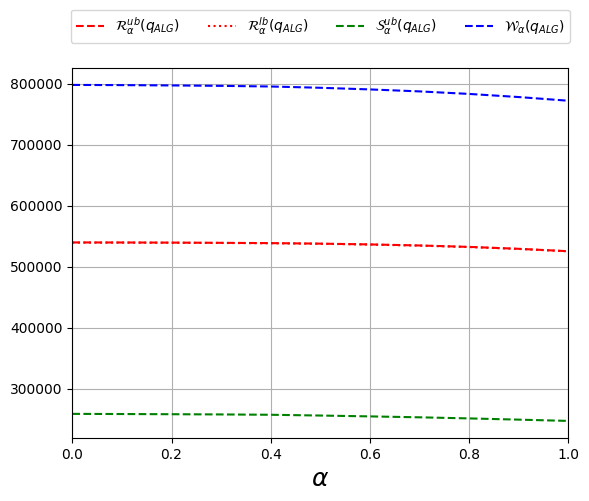

In [ ]:
draw_revenue(revenue_list, total_surplus_list, fairness='Access')

In [ ]:
revenue = revenue_list['lb']
tex = ''
for i in range(len(revenue)):
  #!print('revenue reduction is %.4f percent at alpha %.1f' %(-(revenue_lb[0]-revenue_lb[i])/revenue_lb[0]*100, i/10))
  t = str(round(revenue[i]/revenue[0]*100,2)) + '  '
  tex += t
print(tex)

100.0  99.99  99.95  99.89  99.79  99.64  99.4  99.08  98.65  98.06  97.34  


In [ ]:
tex = ''
for i in range(len(total_surplus_list)):
  #!print('revenue reduction is %.4f percent at alpha %.1f' %(-(revenue_lb[0]-revenue_lb[i])/revenue_lb[0]*100, i/10))
  t = str(round(total_surplus_list[i]/total_surplus_list[0]*100,2)) + '  '
  tex += t
print(tex)

100.0  99.9  99.78  99.65  99.43  98.94  98.4  97.82  97.12  96.34  95.53  


In [ ]:
tex = ''
welfare_list = [revenue[i]+total_surplus_list[i] for i in range(len(total_surplus_list))]
for i in range(len(welfare_list)):
  t = str(round(welfare_list[i]/welfare_list[0]*100,2)) + '  '
  tex += t
print(tex)

100.0  99.96  99.89  99.81  99.68  99.41  99.07  98.67  98.15  97.51  96.75  


<ipython-input-36-039828d75e49>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


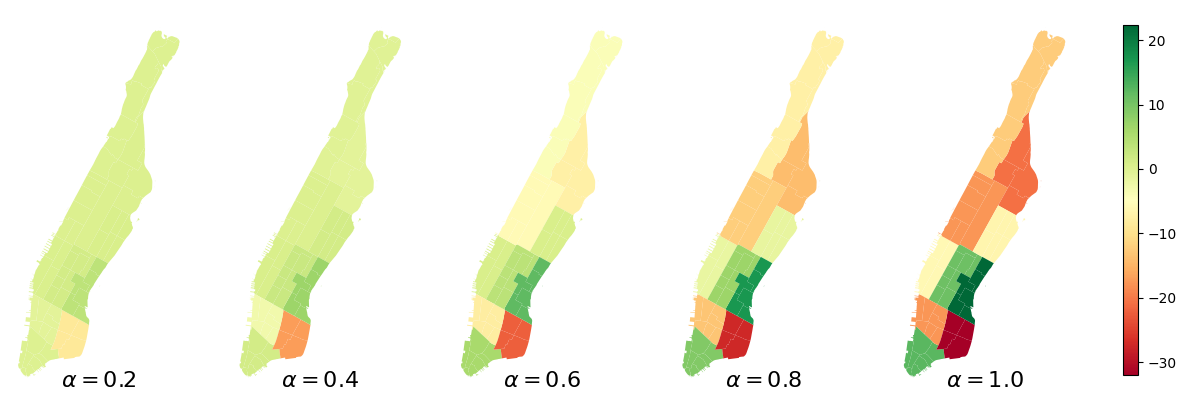

In [ ]:
draw_heatmap(weighted)

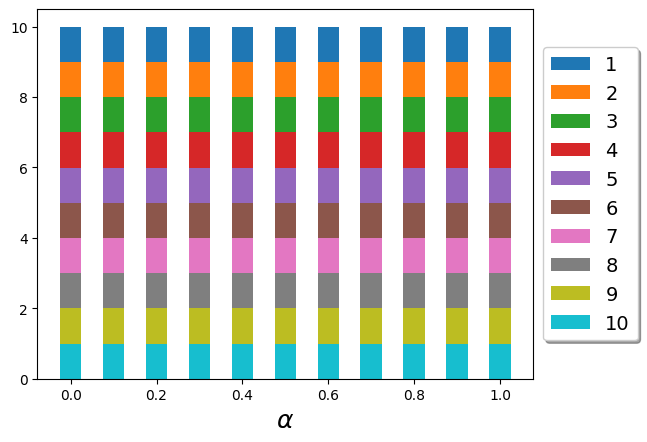

In [ ]:
draw_pi(weighted['pi'])

In [ ]:
top_surplus(surplus_list, k=5)

alpha: 0.1
top 5: [(3, 7), (5, 7), (2, 7), (6, 7), (10, 7)]
bottom 5: [(3, 7), (5, 7), (2, 7), (6, 7), (10, 7)]
alpha: 0.2
top 5: [(3, 7), (5, 7), (2, 7), (6, 7), (10, 7)]
bottom 5: [(3, 7), (5, 7), (2, 7), (6, 7), (10, 7)]
alpha: 0.3
top 5: [(3, 7), (5, 7), (2, 7), (6, 7), (10, 7)]
bottom 5: [(3, 7), (5, 7), (2, 7), (6, 7), (10, 7)]
alpha: 0.4
top 5: [(4, 7), (3, 7), (5, 7), (6, 7), (10, 7)]
bottom 5: [(4, 7), (3, 7), (5, 7), (6, 7), (10, 7)]
alpha: 0.5
top 5: [(4, 7), (5, 7), (7, 10), (6, 7), (10, 7)]
bottom 5: [(4, 7), (5, 7), (7, 10), (6, 7), (10, 7)]
alpha: 0.6
top 5: [(5, 7), (4, 10), (6, 7), (7, 10), (10, 7)]
bottom 5: [(5, 7), (4, 10), (6, 7), (7, 10), (10, 7)]
alpha: 0.7
top 5: [(5, 7), (6, 7), (4, 10), (7, 10), (10, 7)]
bottom 5: [(5, 7), (6, 7), (4, 10), (7, 10), (10, 7)]
alpha: 0.8
top 5: [(6, 10), (4, 10), (6, 7), (7, 10), (10, 7)]
bottom 5: [(6, 10), (4, 10), (6, 7), (7, 10), (10, 7)]
alpha: 0.9
top 5: [(4, 10), (6, 10), (6, 7), (7, 10), (10, 7)]
bottom 5: [(4, 10), (6, 1

## Price Fairness (Each)

In [ ]:
revenue_list, total_surplus_list, surplus_list, p_list, a_list, weighted = algorithm_simulator(param, fairness = 'Price', num_iter=300)

algorithm start
alpha 0.0
Elapsed time: 31.76 minutes
alpha 0.1
Elapsed time: 32.22 minutes
alpha 0.2
Elapsed time: 33.14 minutes
alpha 0.3
Elapsed time: 33.19 minutes
alpha 0.4
Elapsed time: 33.46 minutes
alpha 0.5
Elapsed time: 33.58 minutes
alpha 0.6
Elapsed time: 34.16 minutes
alpha 0.7
Elapsed time: 34.34 minutes
alpha 0.8
Elapsed time: 34.94 minutes
alpha 0.9
Elapsed time: 34.47 minutes
alpha 1.0
Elapsed time: 5.61 minutes


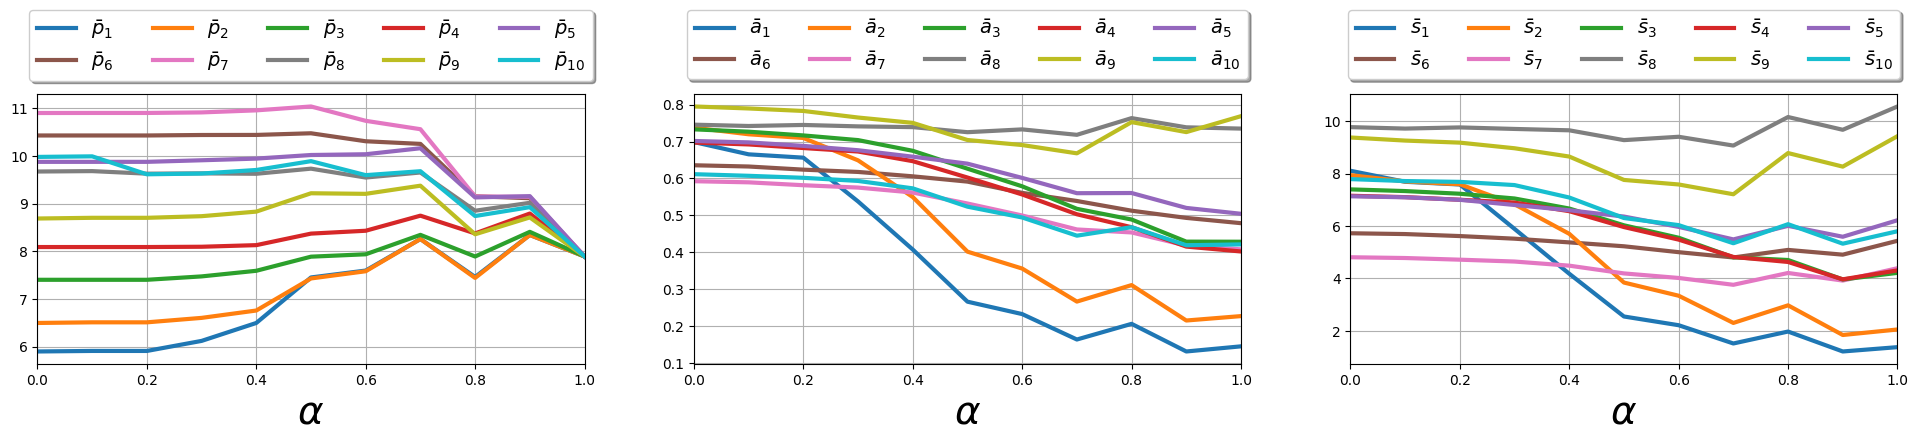

In [ ]:
draw_average(weighted['a_i'], weighted['p_i'], surplus_list, total_surplus_list)

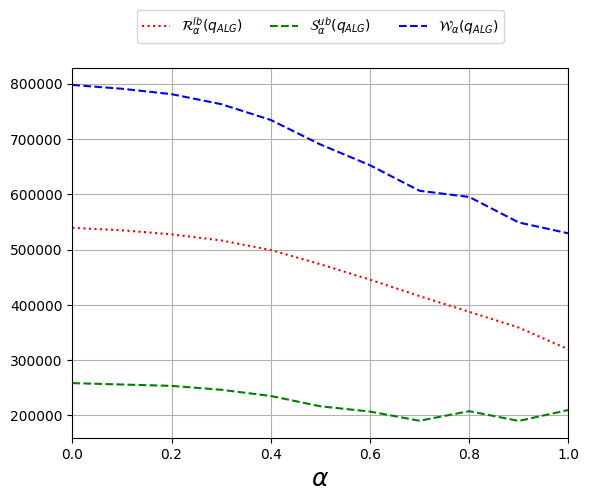

In [ ]:
draw_revenue(revenue_list, total_surplus_list, fairness='Price')

In [ ]:
print(revenue_list)

{'lb': [539265.5466296759, 534840.0163739921, 527523.5578178861, 516527.77087012504, 499144.07809789624, 473481.7877047354, 445506.2390006366, 415827.64137566555, 387390.337531353, 358915.57934763137, 319531.5774800606], 'ub': []}


In [ ]:
print(revenue_list)

{'lb': [539265.5466296759, 534840.0163739921, 527523.5578178861, 516527.77087012504, 499144.07809789624, 473481.7877047354, 445506.2390006366, 415827.64137566555, 387390.337531353, 358915.57934763137, 319531.5774800606], 'ub': []}


In [ ]:
revenue = revenue_list['lb']
tex = ''
for i in range(len(revenue)):
  #!print('revenue reduction is %.4f percent at alpha %.1f' %(-(revenue_lb[0]-revenue_lb[i])/revenue_lb[0]*100, i/10))
  t = str(round(revenue[i]/revenue[0]*100,2)) + '  '
  tex += t
print(tex)

&100.0  &99.18  &97.82  &95.78  &92.56  &87.8  &82.61  &77.11  &71.84  &66.56  &59.25  


In [ ]:
tex = ''
for i in range(len(total_surplus_list)):
  #!print('revenue reduction is %.4f percent at alpha %.1f' %(-(revenue_lb[0]-revenue_lb[i])/revenue_lb[0]*100, i/10))
  t = str(round(total_surplus_list[i]/total_surplus_list[0]*100,2)) + '  '
  tex += t
print(tex)

&100.0  &99.02  &98.09  &95.35  &91.01  &83.78  &80.09  &73.68  &80.37  &73.55  &81.17  


In [ ]:
tex = ''
welfare_list = [revenue[i]+total_surplus_list[i] for i in range(len(total_surplus_list))]
for i in range(len(welfare_list)):
  #!print('revenue reduction is %.4f percent at alpha %.1f' %(-(revenue_lb[0]-revenue_lb[i])/revenue_lb[0]*100, i/10))
  t = str(round(welfare_list[i]/welfare_list[0]*100,2)) + '  '
  tex += t
print(tex)

&100.0  &99.13  &97.91  &95.64  &92.06  &86.5  &81.8  &76.0  &74.6  &68.82  &66.35  


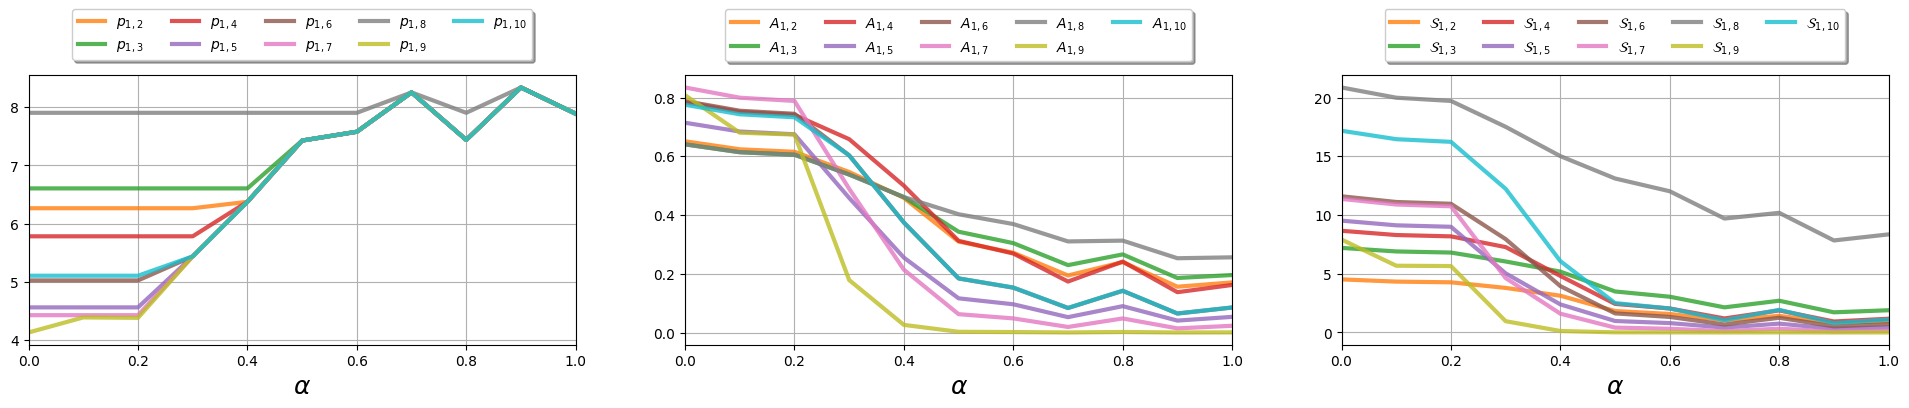

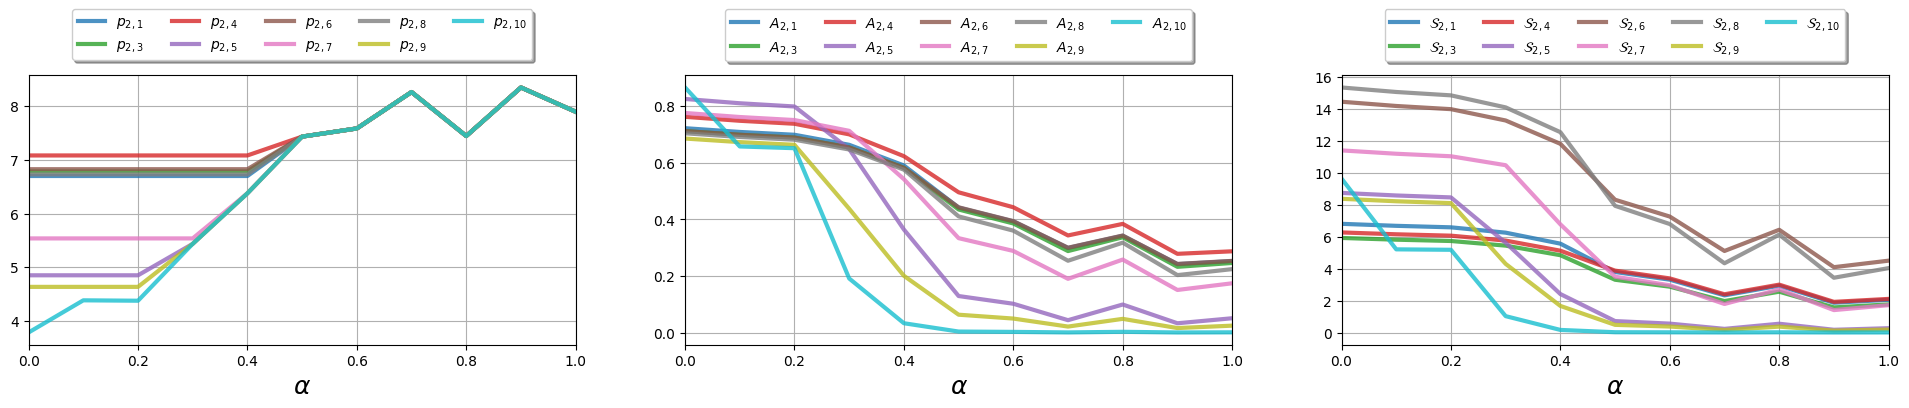

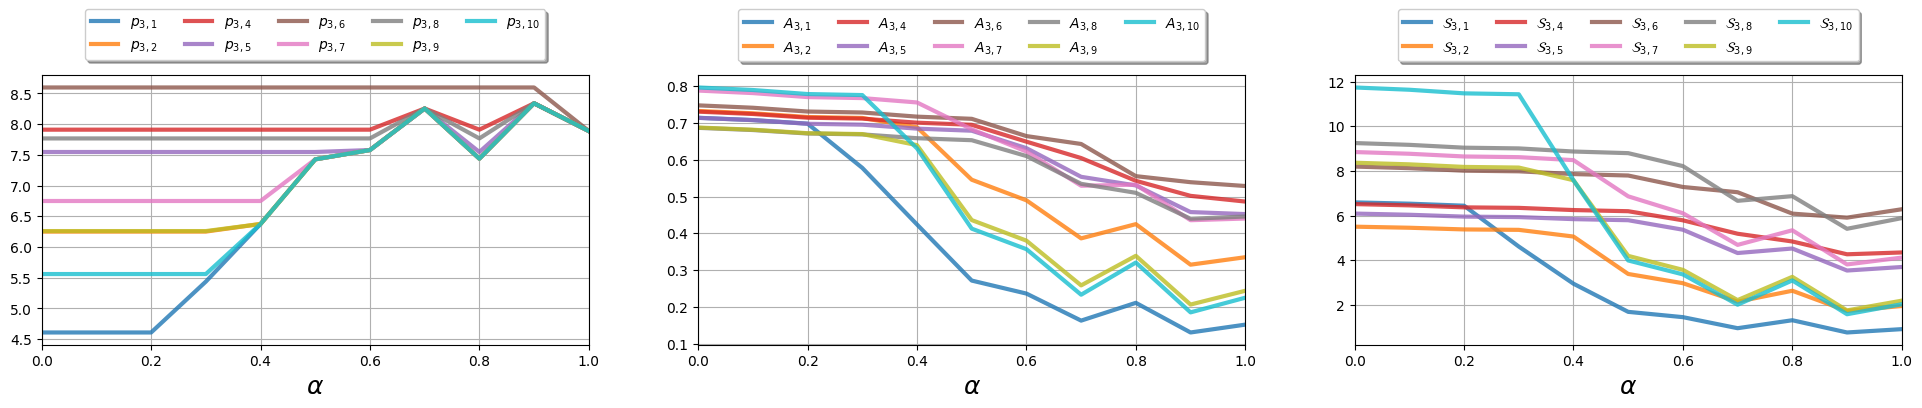

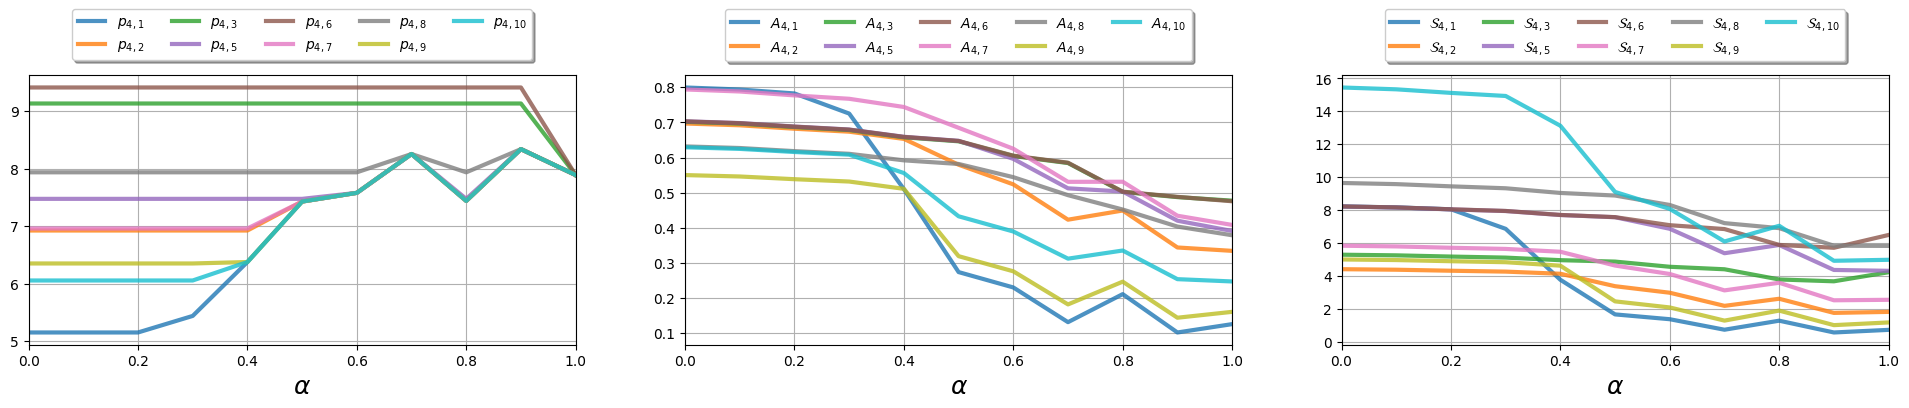

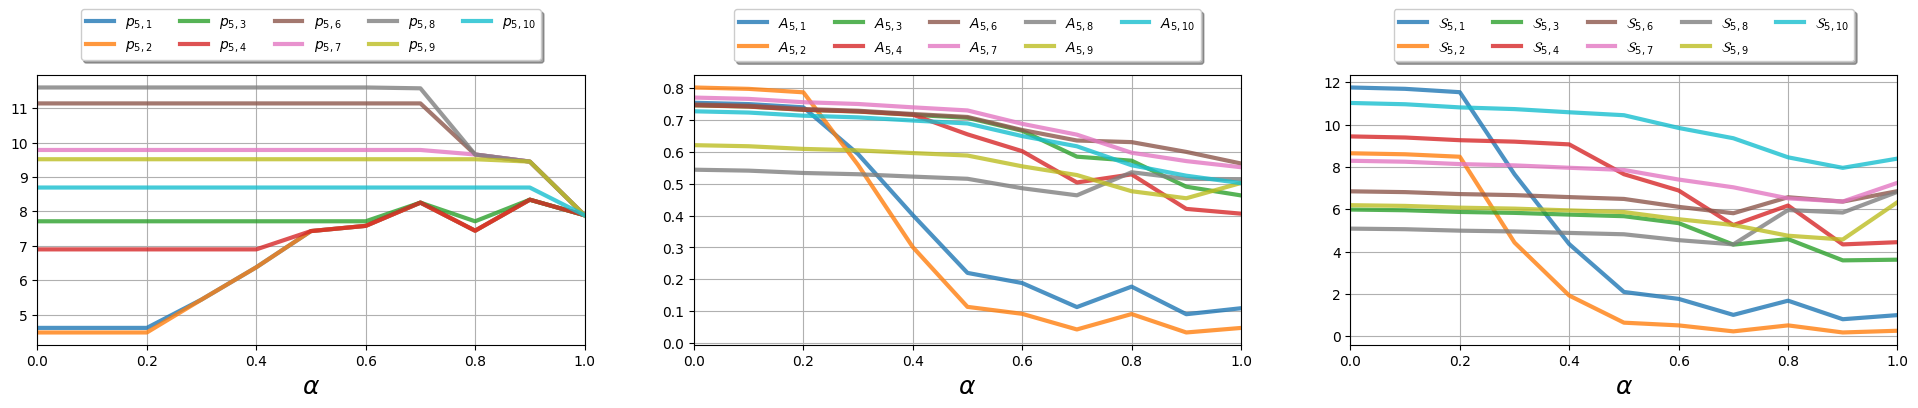

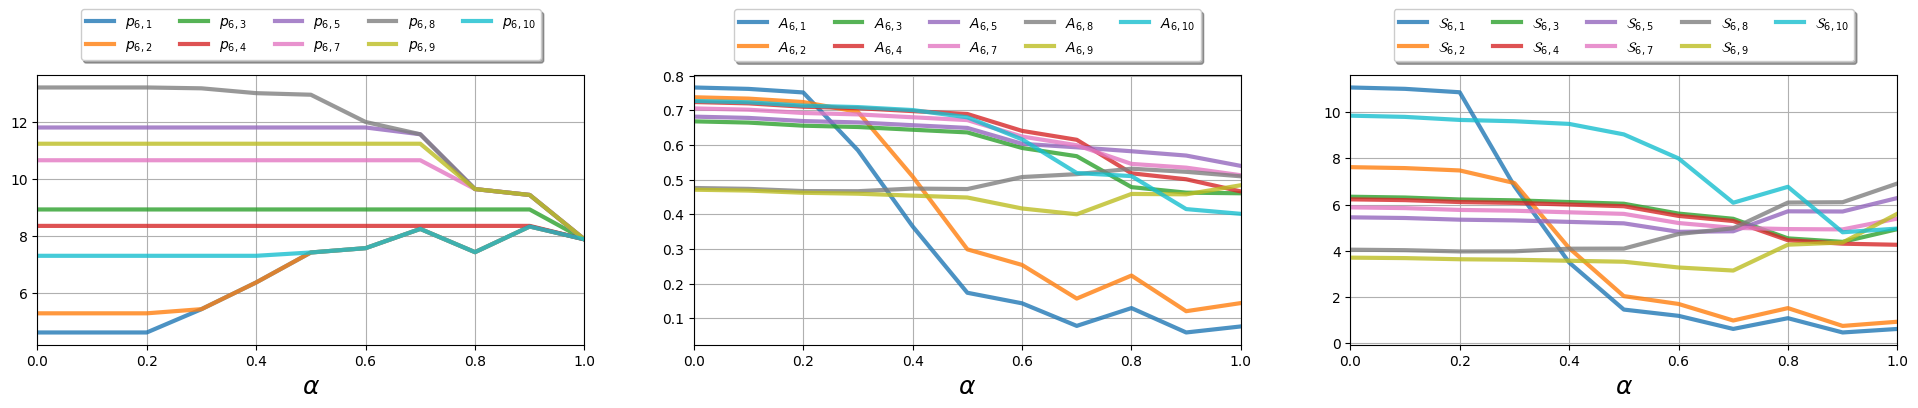

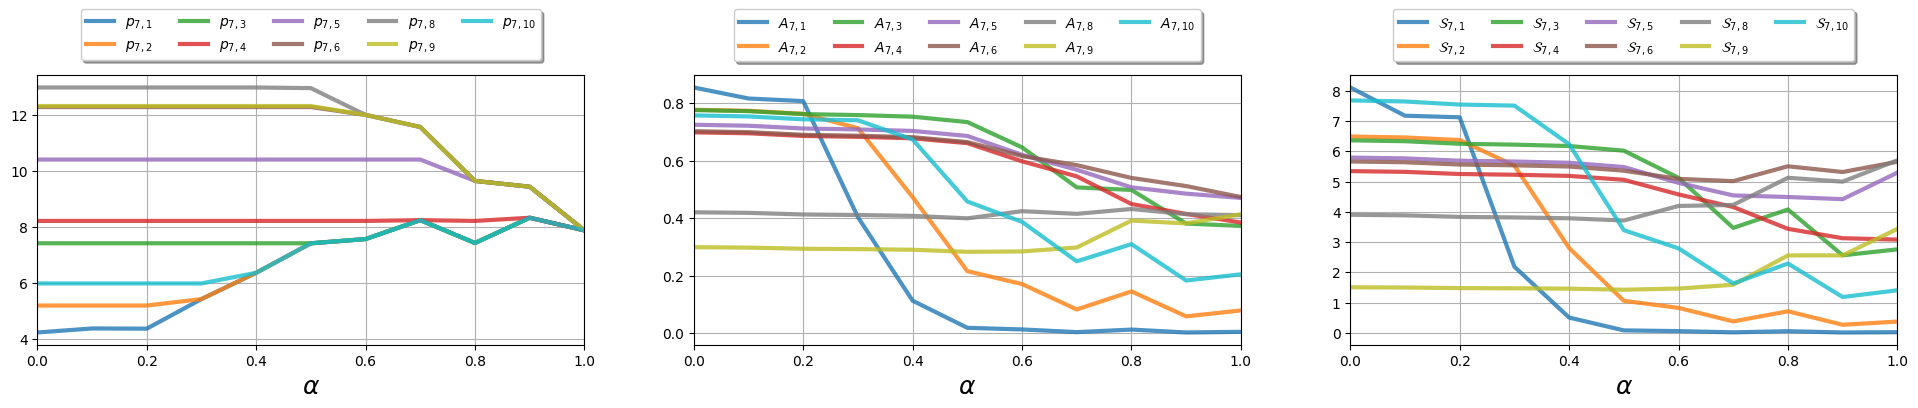

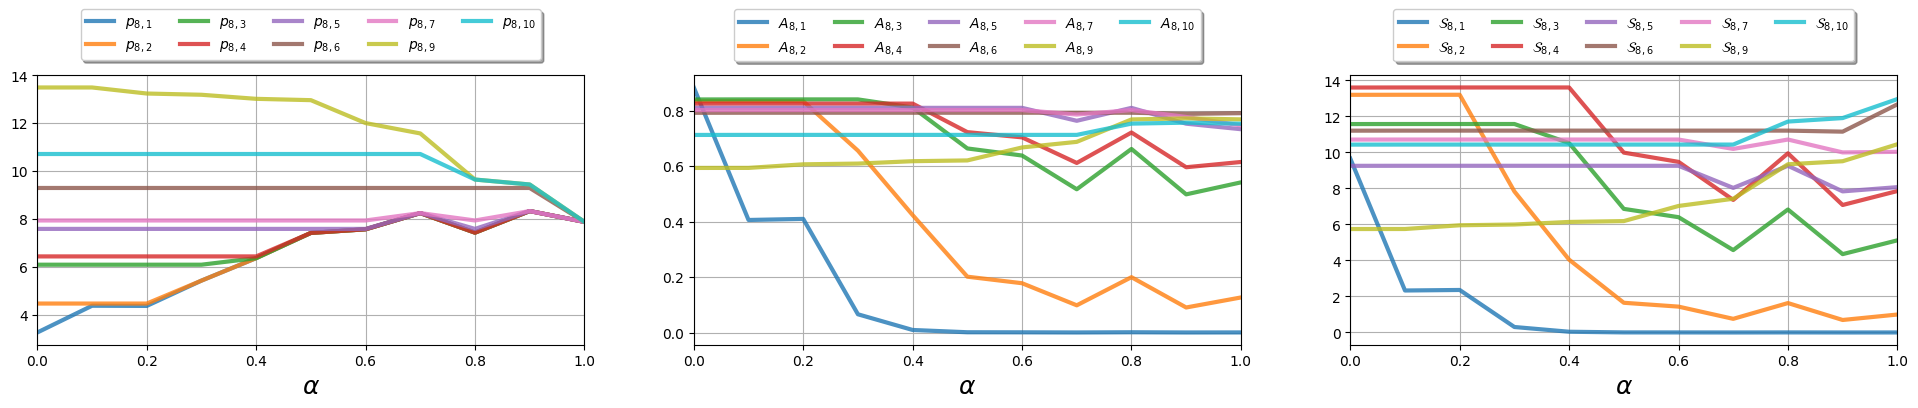

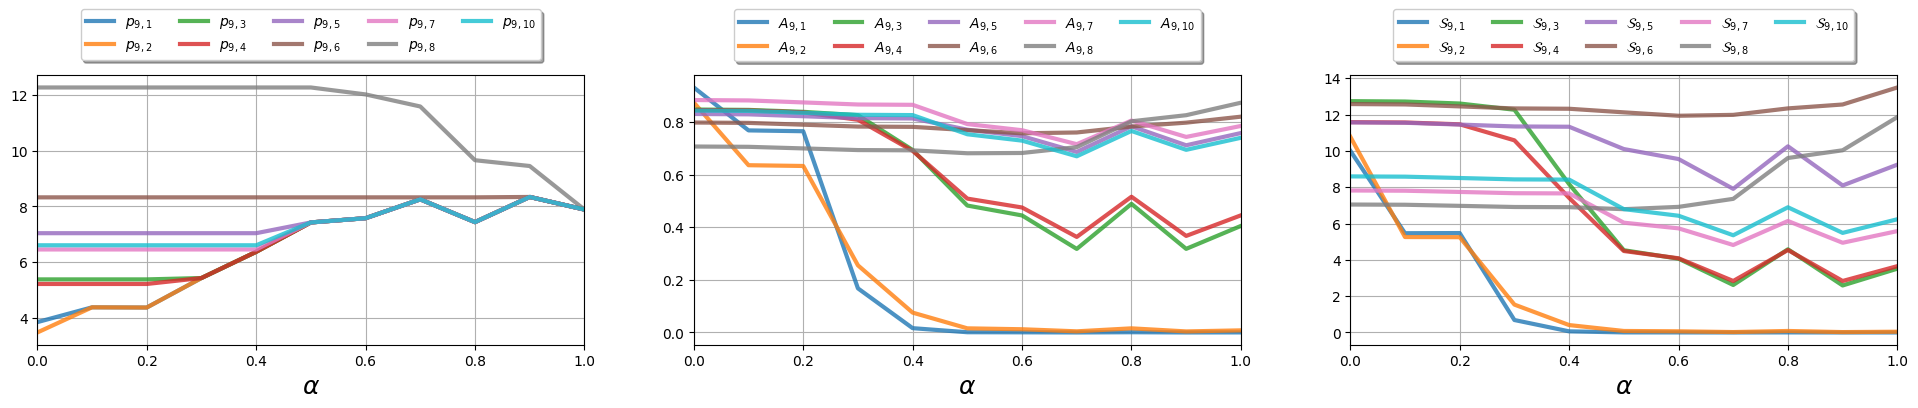

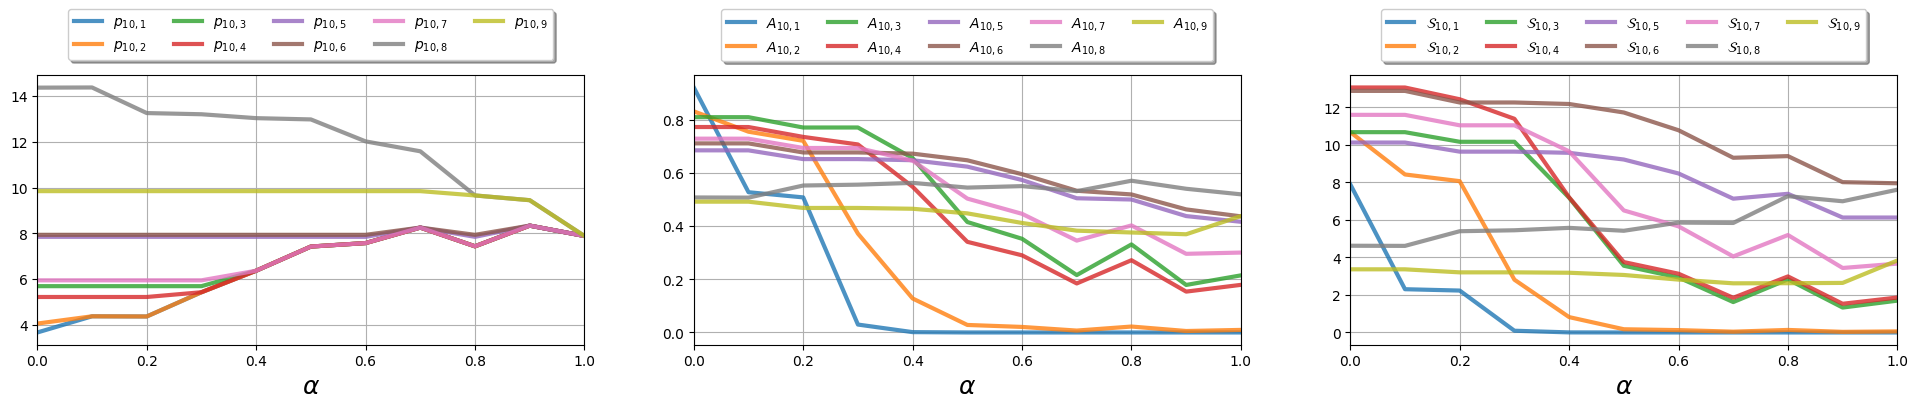

In [ ]:
L = [i for i in range(1,11)]
norm = {(i,j): 1 for i in L for j in L}
for i in range(1, max(p_list[0].keys())[0]+1):
  subplot_drawing(b, p_list, a_list, surplus_list, total_surplus_list, d = param['d'], origin = i)

<ipython-input-32-8e370b010551>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


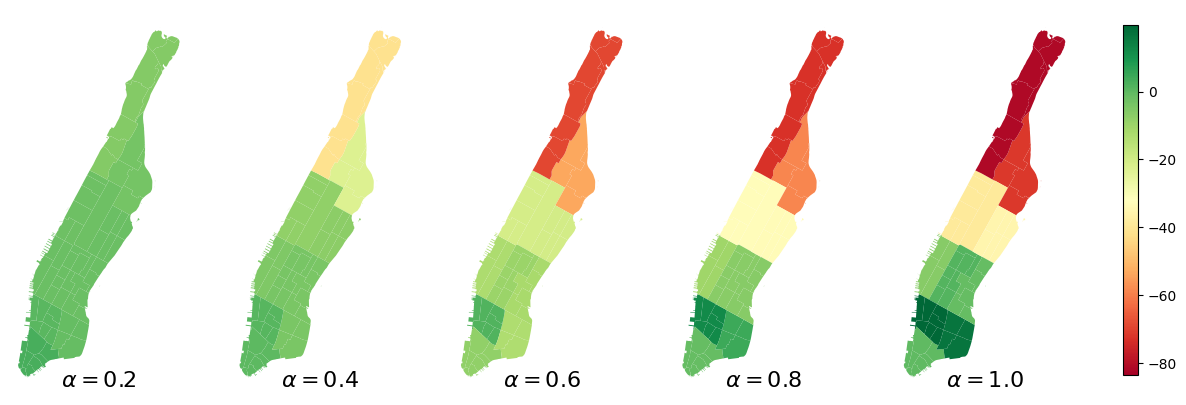

In [ ]:
draw_heatmap(weighted)

<ipython-input-28-772c3b91070f>:55: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  fig.legend(handles=new_legend.legendHandles, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=10, prop={"size": 18})  # Adjust font size


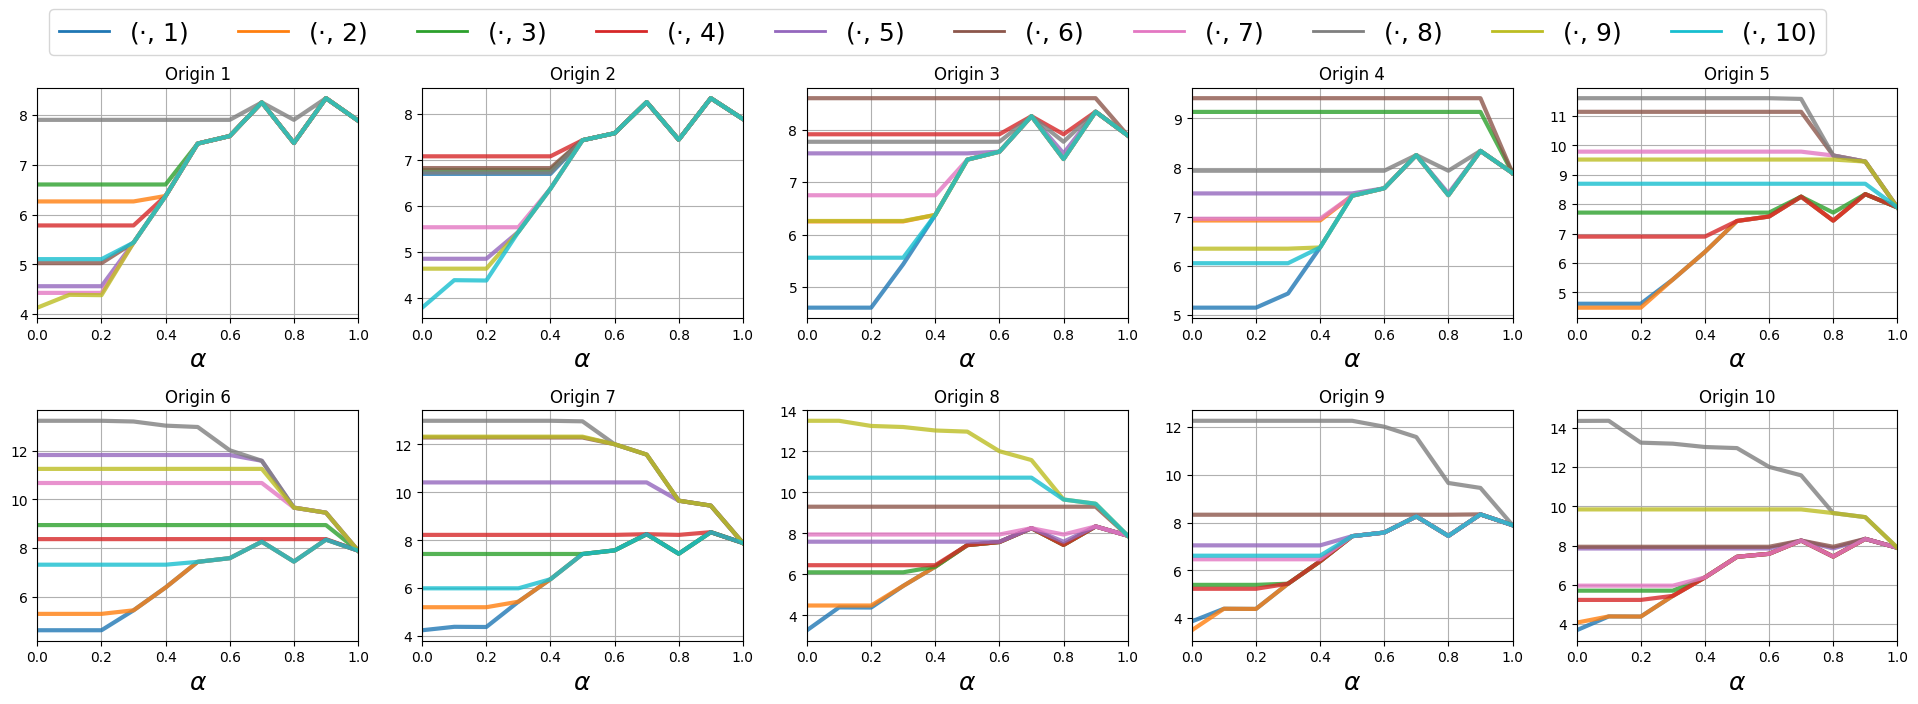

<Figure size 640x480 with 0 Axes>

In [ ]:
subplot_price(p_list, param['d'])

<ipython-input-28-772c3b91070f>:55: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  fig.legend(handles=new_legend.legendHandles, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=10, prop={"size": 18})  # Adjust font size


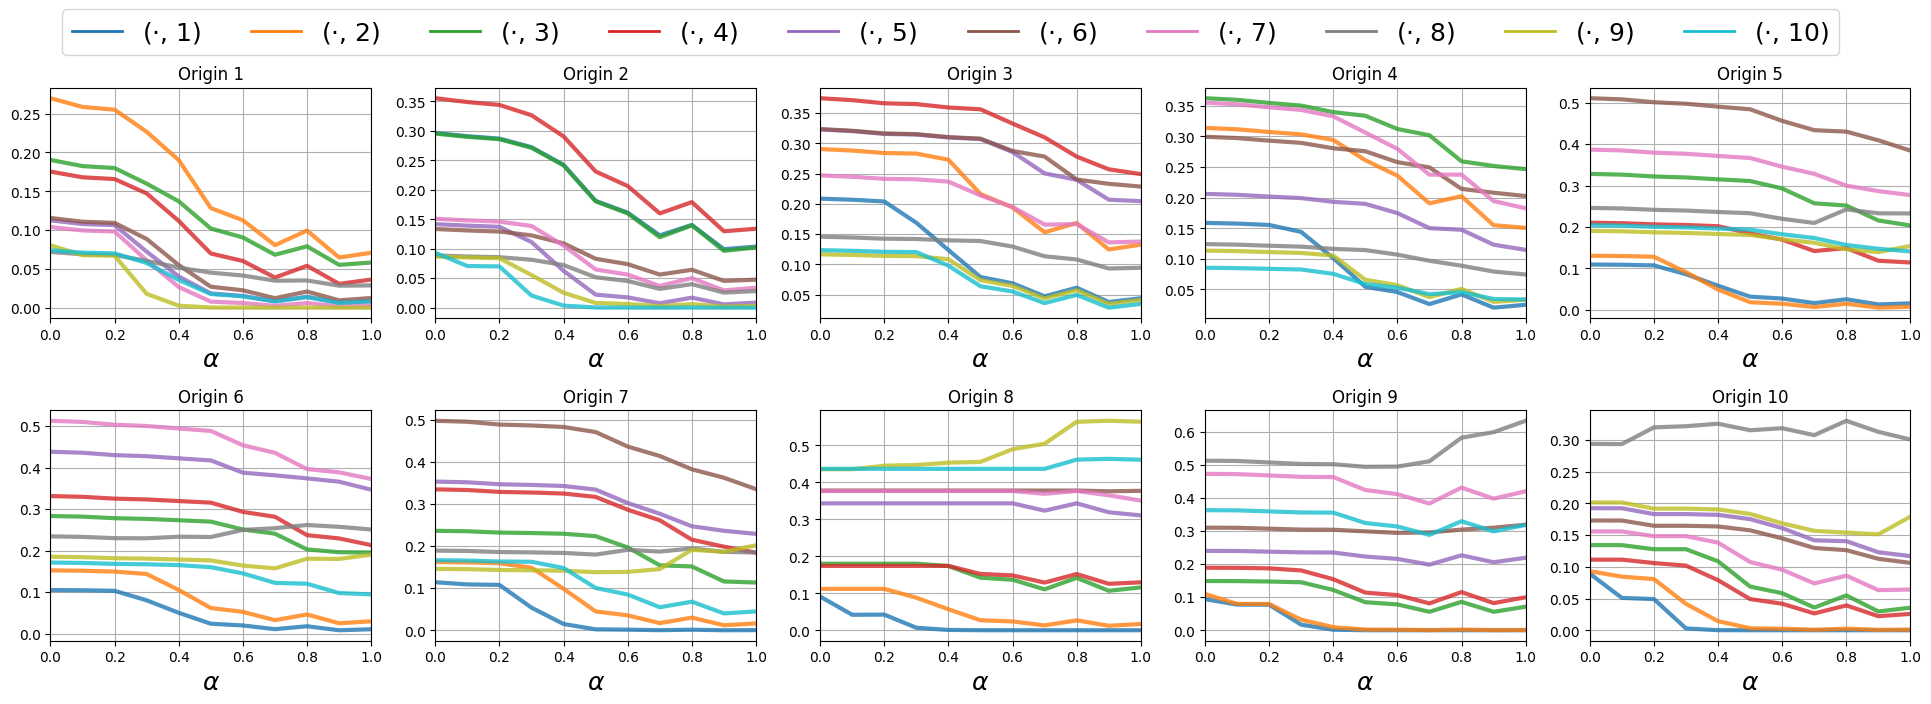

<Figure size 640x480 with 0 Axes>

In [ ]:
subplot_price(a_list, param['d'])

[{1: 0.9988713566350848, 2: 0.9993845541885239, 3: 0.999517777013652, 4: 0.9995431845340251, 5: 0.9995762966472304, 6: 0.999578202191456, 7: 0.9995818111808704, 8: 0.9997354626493533, 9: 0.999601660670664, 10: 0.9996131707724374}, {1: 0.9571180987337892, 2: 0.9809900371772787, 3: 0.9908415891054552, 4: 0.9922758509140981, 5: 0.9941068321360406, 6: 0.9942283764327804, 7: 0.9949267992457946, 8: 0.9999999760176396, 9: 0.9979512386745131, 10: 0.9994651607691507}, {1: 0.9439759613475428, 2: 0.9672064040068115, 3: 0.9770568599874837, 4: 0.9782485492081026, 5: 0.9806139526135915, 6: 0.9808578928537084, 7: 0.9816328005376802, 8: 1.0, 9: 0.9893445794930764, 10: 0.951508511810076}, {1: 0.838513561210644, 2: 0.9181378285296501, 3: 0.9735811094039001, 4: 0.9661494330413335, 5: 0.9733327043097517, 6: 0.9751137053819097, 7: 0.9771660412128154, 8: 1.0, 9: 0.9804471988021474, 10: 0.9516048501401113}, {1: 0.7189918477104078, 2: 0.8170910406699154, 3: 0.9585028013156133, 4: 0.936732072187692, 5: 0.95967

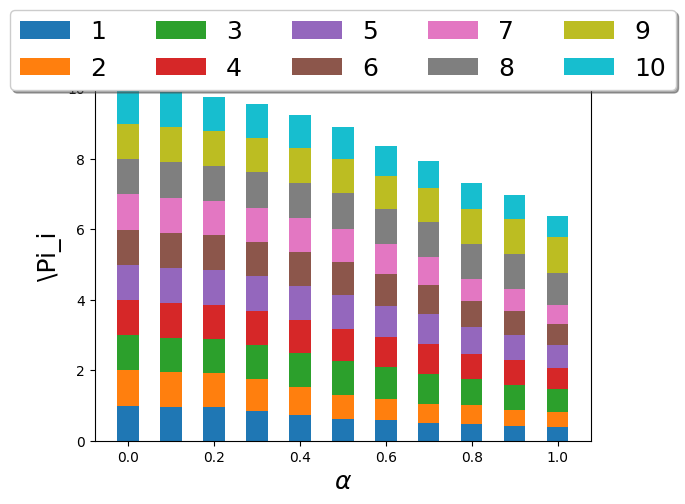

In [ ]:
draw_pi(weighted['pi'])

In [ ]:
import pickle
results = {}
results['revenue_list'] = revenue_list
results['total_surplus_list'] = total_surplus_list
results['surplus_list'] = surplus_list
results['p_list'] = p_list
results['a_list'] = a_list
results['weighted'] = weighted
filename = os.path.join(pwd, 'results_price_fair.pkl')
with open(filename, 'wb') as f:
    pickle.dump(results, f)